# コメント頻度やMACDによってバースト判定した箇所ごとのコメントの特性を分析する
- 指定区間のコメントよりタグクラウドを作成するのはどうか？
    1. 全コメントより作成したタグクラウドと比較して特性の違いが見られないか確認しよう
    2. 区間ごとに、コメントの頻度ベクトルが得られる、これを次元削減して2次元平面状にプロットすることで違いが見られないか？

In [74]:
import os
import sys
sys.path.append('../src')
sys.path.append('../utility')
import datetime
import time
import importlib
from collections import Counter

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt

import japanize_matplotlib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
import neologdn

from bidirectional_map import BidiMap
import similarity as sim
import macd
import create_wordcloud as wc
importlib.reload(macd)
importlib.reload(sim)
importlib.reload(wc)

from comment_preprocessing import reformat_time
import matplotlib_wrapper as mw
importlib.reload(mw)

<module 'matplotlib_wrapper' from '../utility/matplotlib_wrapper.py'>

In [92]:
video_id_list = [
    "RPqSnJez-YI",
    "-sJSuDcPKRw",
    "HCsLM8I-ZEg",
    "c6od-g02MLk"
]
video_id = video_id_list[0]
file = os.path.join("../data/comments", video_id_list[0]+".tsv")
print(file)
df = pd.read_csv(file, sep="\t")
df = df[~df.publishedAt.str.startswith('-')]
df.index = pd.to_timedelta(df.apply(lambda x: reformat_time(x.publishedAt), axis=1))
df['freq'] = 1

../data/comments/RPqSnJez-YI.tsv


### コメントデータの前処理を行う
- neologdn方式で文字列を正規化する

In [93]:
df['displayMessage'] = df.apply(lambda x: neologdn.normalize(x.displayMessage, repeat=2), axis=1)

# 一定間隔でコメント頻度をリサンプリングして分析に用いる
- 今回は動画が長いので60秒間隔

In [94]:
df['counter'] = df.apply(lambda x: Counter([x.displayMessage]), axis=1)
resampled = df.resample("60s")

resampled_freq = resampled['freq'].sum()
resampled_counter = resampled['counter'].sum()
df_resampled = pd.concat([resampled_freq, resampled_counter], axis=1)
df_resampled['total_sec'] = df_resampled.index.total_seconds().astype(int)
df_resampled['url'] = df_resampled['total_sec'].apply(lambda t: 'https://www.youtube.com/watch?v=%s&t=%s' % (video_id, t))
# リサンプリングしたtimedeltaとそのインデックスの双方向map
time_mapper = BidiMap(resampled_freq.index.to_series().reset_index(drop=True).to_dict())

In [95]:
df_resampled.head()

freq                                            counter  total_sec  \
00:00:01   273  {'当たっていい当たっていい': 1, 'やあ': 151, 'なにやってんだよ': 1, ...          1   
00:01:01   225  {'やあ': 48, '日本テレコム': 7, '初見です': 1, '加藤純一さんがオンラ...         61   
00:02:01   241  {'やあ': 21, '久しぶりのマリメ': 1, 'だっせー': 1, 'むっず': 1,...        121   
00:03:01   207  {'有能': 16, '猫マリオ知らんもんな': 1, 'おい純、栄冠はどうなったんだ今日や...        181   
00:04:01   243  {'優しいな': 1, '有能': 12, 'ありがたいねえ': 1, 'チュートリアルあっ...        241   

                                                        url  
00:00:01    https://www.youtube.com/watch?v=RPqSnJez-YI&t=1  
00:01:01   https://www.youtube.com/watch?v=RPqSnJez-YI&t=61  
00:02:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=121  
00:03:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=181  
00:04:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=241

# コメント頻度の時系列データより，MACDを計算する

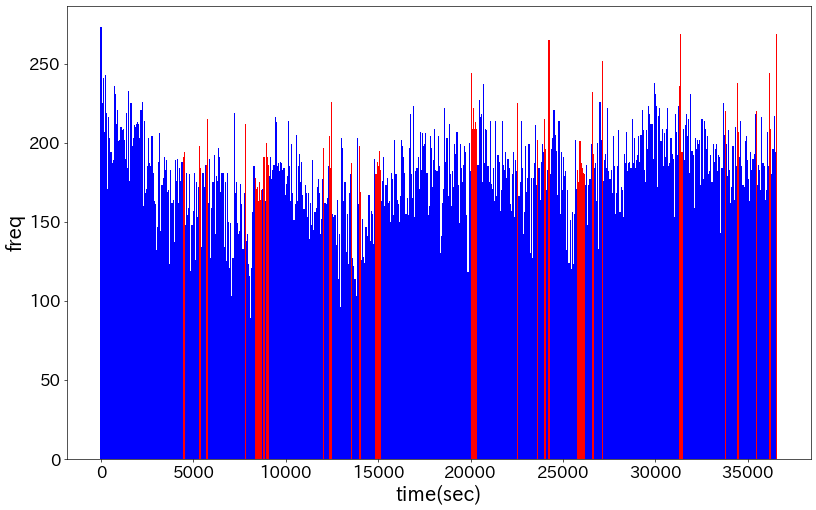

In [96]:
x = df_resampled['total_sec'].values
y = df_resampled['freq'].values
macd_hist = macd.calc_macd(x, y, f=26, s=12, t=9)
df_resampled = pd.merge(df_resampled[['counter', 'total_sec', 'url']], macd_hist, left_on="total_sec", right_index=True)

mw.bar_timeseries(x,y, label=['r' if hist > 3.0 else 'b' for hist in macd_hist['hist']], width=60)

In [97]:
df_resampled.head()

counter  total_sec  \
00:00:01  {'当たっていい当たっていい': 1, 'やあ': 151, 'なにやってんだよ': 1, ...          1   
00:01:01  {'やあ': 48, '日本テレコム': 7, '初見です': 1, '加藤純一さんがオンラ...         61   
00:02:01  {'やあ': 21, '久しぶりのマリメ': 1, 'だっせー': 1, 'むっず': 1,...        121   
00:03:01  {'有能': 16, '猫マリオ知らんもんな': 1, 'おい純、栄冠はどうなったんだ今日や...        181   
00:04:01  {'優しいな': 1, '有能': 12, 'ありがたいねえ': 1, 'チュートリアルあっ...        241   

                                                        url  freq      ema_12  \
00:00:01    https://www.youtube.com/watch?v=RPqSnJez-YI&t=1   273  273.000000   
00:01:01   https://www.youtube.com/watch?v=RPqSnJez-YI&t=61   225  247.000000   
00:02:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=121   241  244.658199   
00:03:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=181   207  232.770977   
00:04:01  https://www.youtube.com/watch?v=RPqSnJez-YI&t=241   243  235.550166   

              ema_26      macd    signal      hist  
00:00:01  273.000000  0.000000  0.000000  0.000000  
00:01:01  248.076923 -1.076923 -0.598291 -0.478632  
00:02:01  245.534253 -0.876055 -0.712128 -0.163926  
00:03:01  234.761760 -1.990783 -1.145277 -0.845506  
00:04:01  236.672242 -1.122076 -1.138375  0.016299

# 全単語のワードクラウドを作成

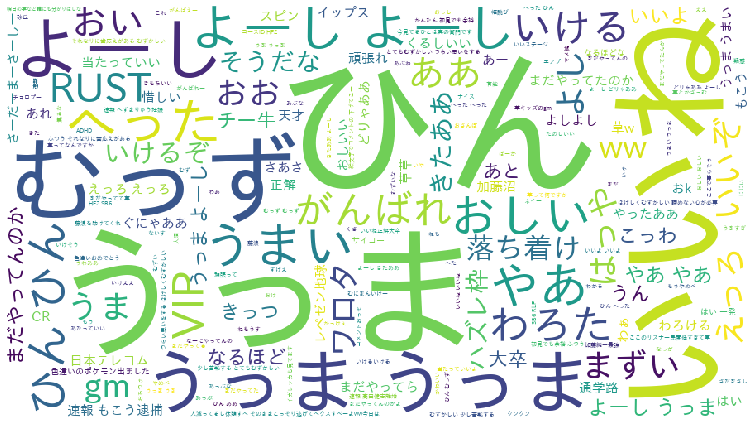

In [98]:
wc.create_from_list(df['displayMessage'].values)

# 配信の各シーンごとにワードクラウドを作成する
- 盛り上がり方にも種類があって、シーンごとに変わるのでは？
- 例
    1. うまいプレーで称賛のコメント
    2. 下手なプレーで罵詈雑言の嵐
    3. 面白いシーンで「ｗｗｗ」みたいな笑いの感情を表すコメント
    4. 荒らしコメントやスパム、それに反応するコメント

### コメントの頻度が高いシーン上位5つを比較してみる
- 枠の最初は特にコメントの密度が多い
- 視聴者全体が割と素直な反応を示すので，見どころが捉えられてる場合が多い

0 days 00:00:01 freq:  273 https://www.youtube.com/watch?v=RPqSnJez-YI&t=1


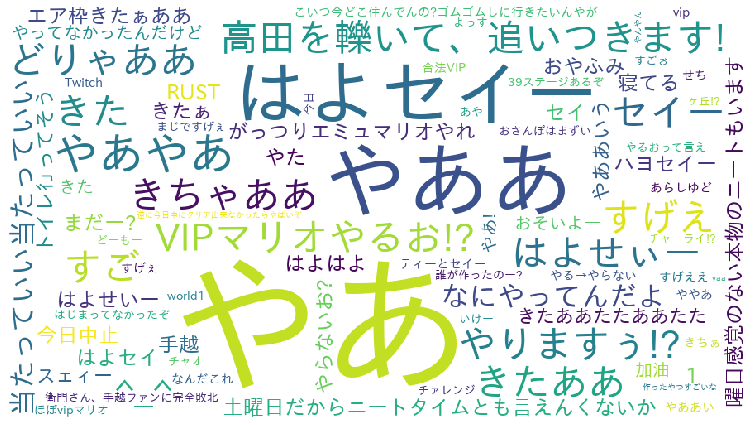

0 days 08:43:01 freq:  269 https://www.youtube.com/watch?v=RPqSnJez-YI&t=31381


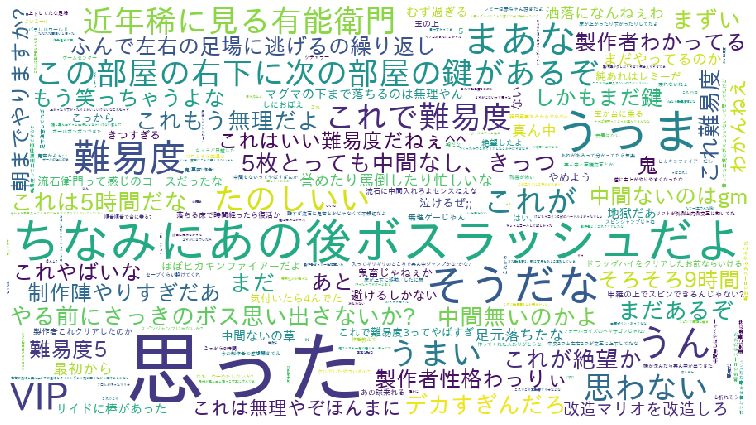

0 days 10:09:01 freq:  269 https://www.youtube.com/watch?v=RPqSnJez-YI&t=36541


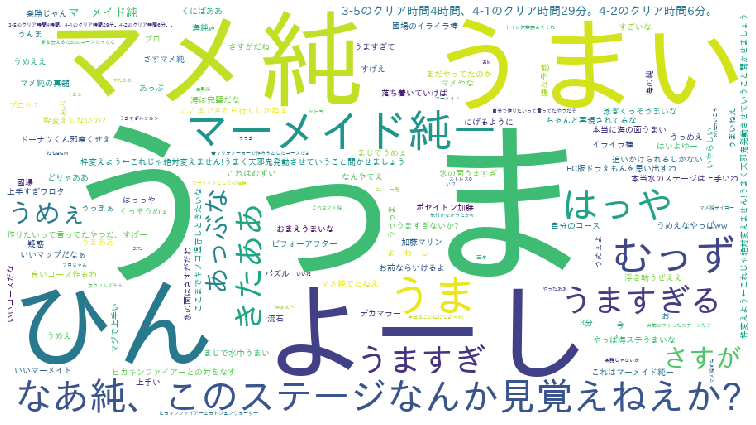

0 days 06:44:01 freq:  265 https://www.youtube.com/watch?v=RPqSnJez-YI&t=24241


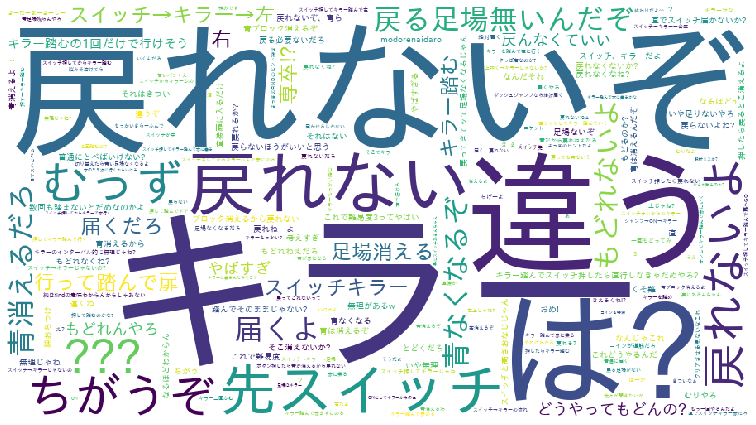

0 days 07:32:01 freq:  252 https://www.youtube.com/watch?v=RPqSnJez-YI&t=27121


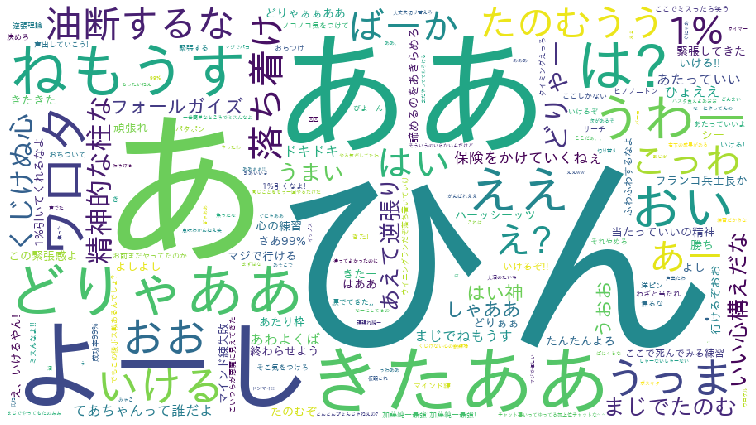

In [100]:
import pandas.tseries.offsets as offsets
# 盛り上がったシーンの前後t_offset間のコメントを利用する
t_offset = 30

for t, scene in df_resampled[['counter', 'freq', 'hist', 'url']].sort_values('freq', ascending=False)[:5].iterrows():
    freq = scene.freq
    url = scene.url
    print(t, "freq: ", freq, url)
    wc.create_from_dict(sum(resampled_counter[t-offsets.Second(t_offset):t+offsets.Second(t_offset)], Counter()))

### MACD上位5シーンを比較してみる
- つまらないシーンの時の，1人の連投に反応してしまってる
    - コメント頻度ではなく，コメントしたユーザ数の推移でMACDを算出してみるのはどうか？

0 days 08:43:01 MACDhist:  6.530537532014262 https://www.youtube.com/watch?v=RPqSnJez-YI&t=31381


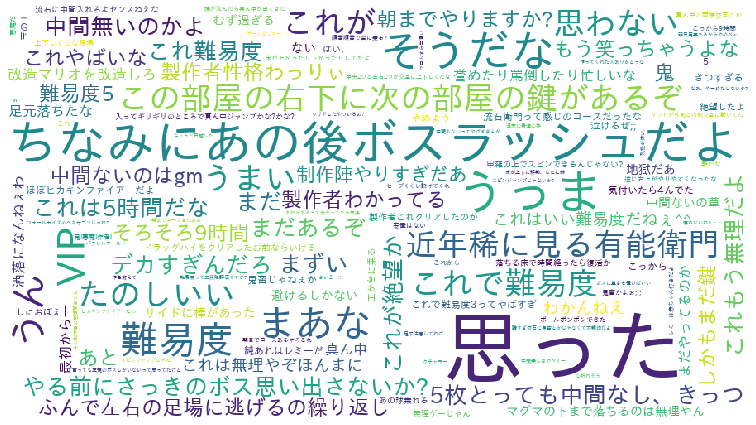

0 days 03:28:01 MACDhist:  5.791107921647638 https://www.youtube.com/watch?v=RPqSnJez-YI&t=12481


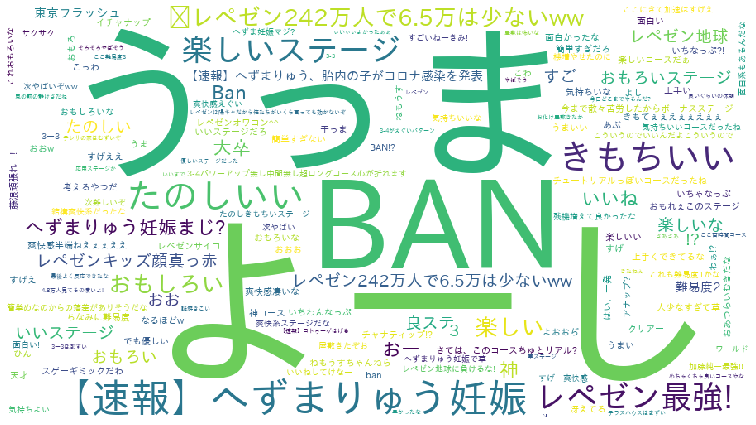

0 days 10:09:01 MACDhist:  5.353742146395891 https://www.youtube.com/watch?v=RPqSnJez-YI&t=36541


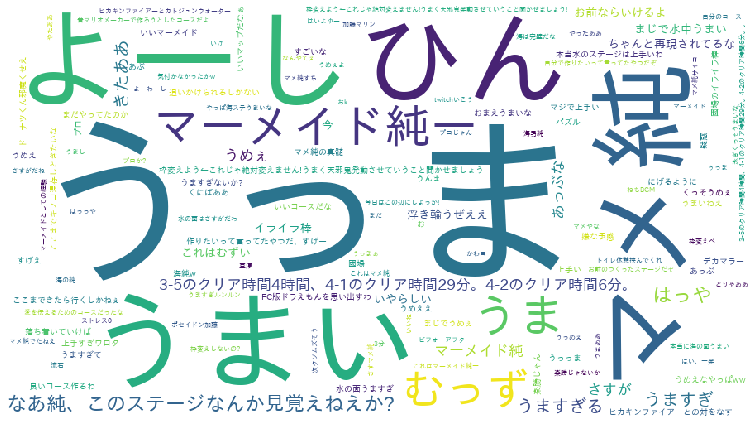

0 days 07:12:01 MACDhist:  5.325660240911393 https://www.youtube.com/watch?v=RPqSnJez-YI&t=25921


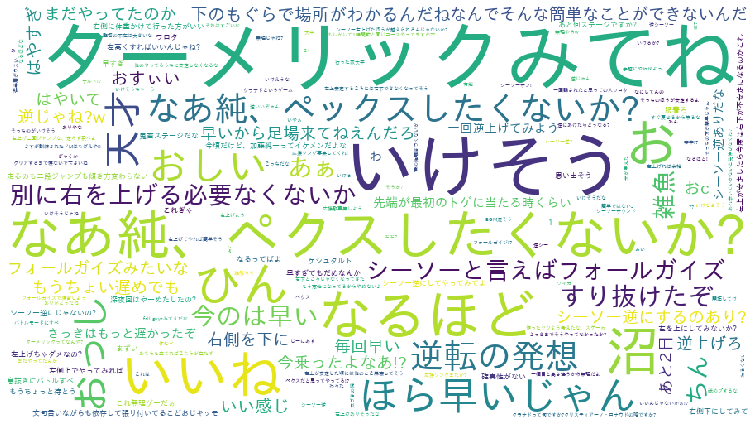

0 days 04:11:01 MACDhist:  5.27236961785915 https://www.youtube.com/watch?v=RPqSnJez-YI&t=15061


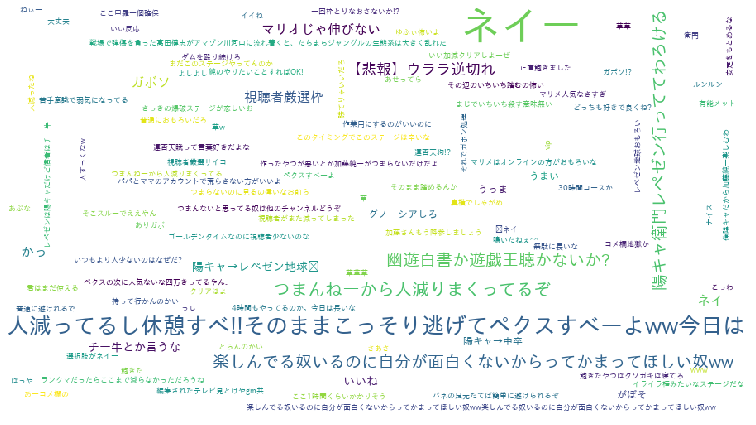

In [101]:
import pandas.tseries.offsets as offsets
# 盛り上がったシーンの前後t_offset間のコメントを利用する
t_offset = 30

for t, scene in df_resampled[['counter', 'freq', 'hist', 'url']].sort_values('hist', ascending=False)[:5].iterrows():
    hist = scene['hist']
    url = scene['url']
    print(t, "MACDhist: ", hist, url)
    wc.create_from_dict(sum(resampled_counter[t-offsets.Second(t_offset):t+offsets.Second(t_offset)], Counter()))

# シーンごとの単語の出現頻度をベクトル化して、シーン間のコメントの特性の違いを可視化したい

In [102]:
# 15秒ごとの単語の出現頻度をベクトル化する
V = DictVectorizer()
X = V.fit_transform(resampled_counter)
# V.get_feature_names()

### コメントベクトルを次元削減

In [103]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

print(X.shape)
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)
print(X_reduced.shape)

(610, 60899)
(610, 2)


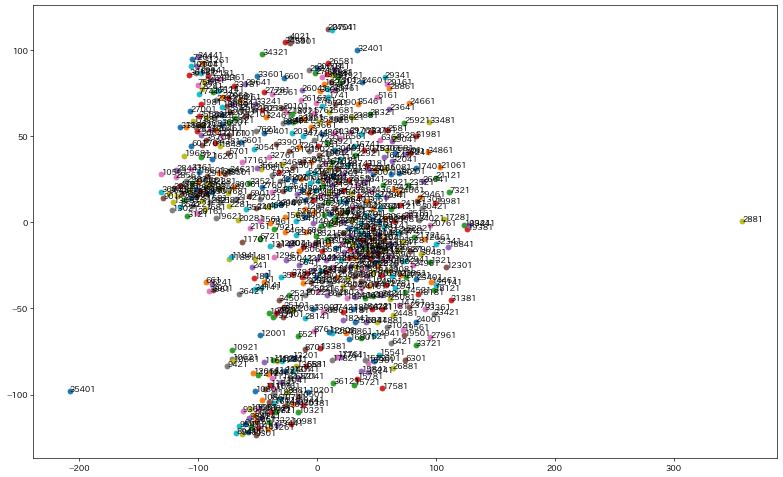

In [104]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=60)

time_index = resampled_counter.index.total_seconds().astype(int)
for label, x, y in zip(time_index, X_reduced[:,0], X_reduced[:,1]):
    ax.scatter(x, y)
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

# 類似度が高いコメントの区間を判定する
- コサイン類似度を用いる

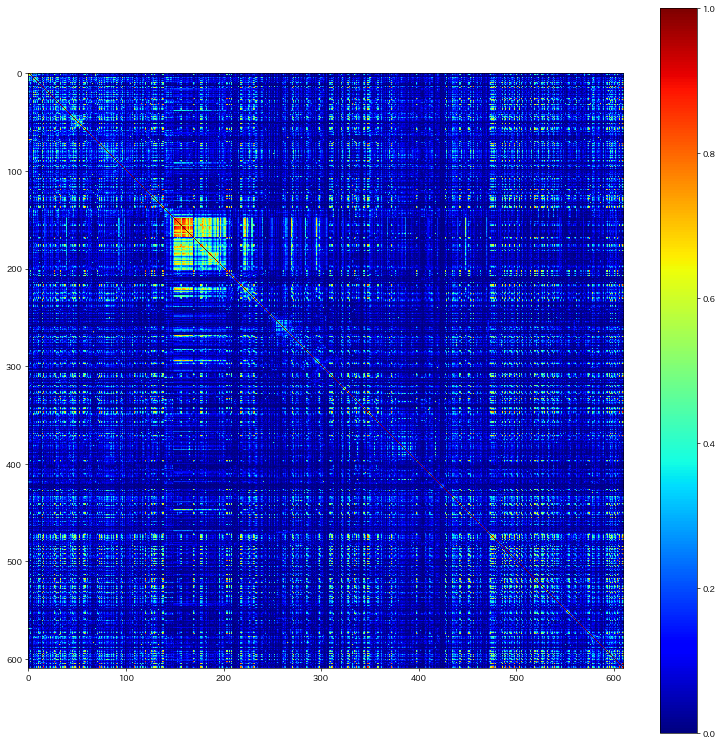

In [106]:
cos_sim = sim.cos_sims(X)
cos_sim.shape

fig, ax = plt.subplots(figsize=(16,16), dpi=60)
im = ax.imshow(cos_sim.todense(),interpolation='nearest',vmin=0,vmax=1, cmap='jet')
plt.colorbar(im)
plt.show()

    target     item  similarity
0 05:36:01 05:36:01    1.000000
1 05:36:01 10:09:01    0.711348
2 05:36:01 10:08:01    0.707044
3 05:36:01 01:30:01    0.693918
4 05:36:01 05:11:01    0.684764
time0 days 05:36:01: 0 days 05:36:01. similarity:1.0000000000000044 https://www.youtube.com/watch?v=RPqSnJez-YI&t=20161


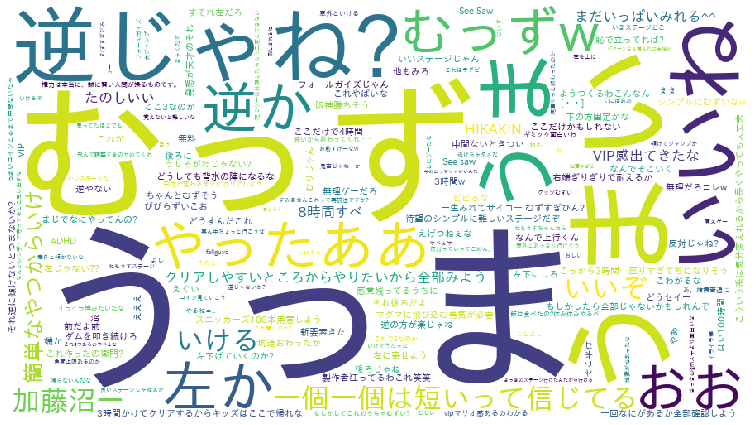

time0 days 05:36:01: 0 days 10:09:01. similarity:0.711348426781026 https://www.youtube.com/watch?v=RPqSnJez-YI&t=36541


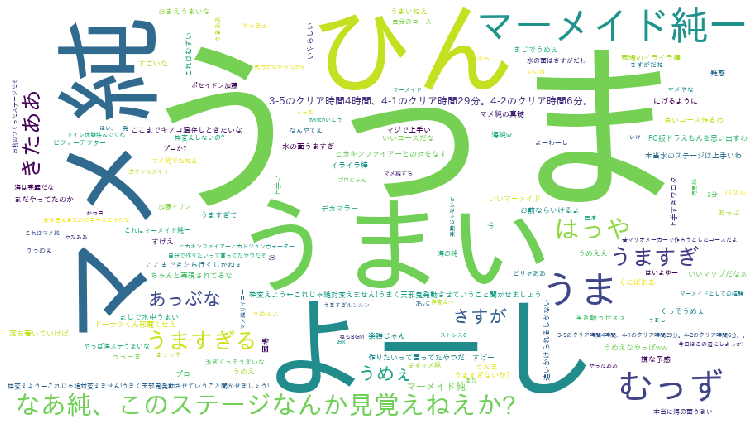

time0 days 05:36:01: 0 days 10:08:01. similarity:0.7070436113669806 https://www.youtube.com/watch?v=RPqSnJez-YI&t=36481


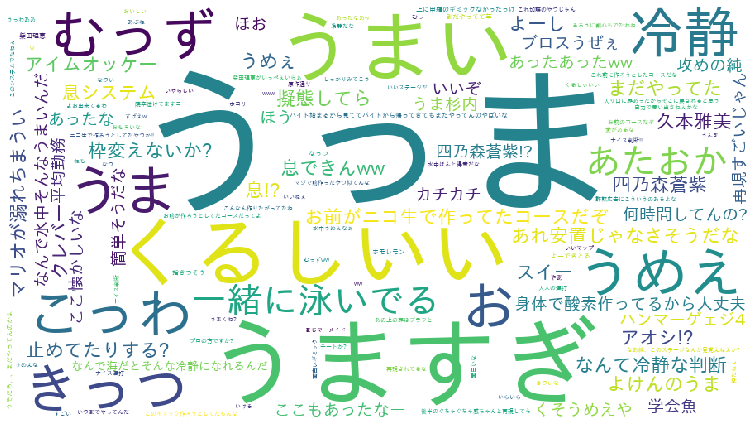

time0 days 05:36:01: 0 days 01:30:01. similarity:0.6939177650252759 https://www.youtube.com/watch?v=RPqSnJez-YI&t=5401


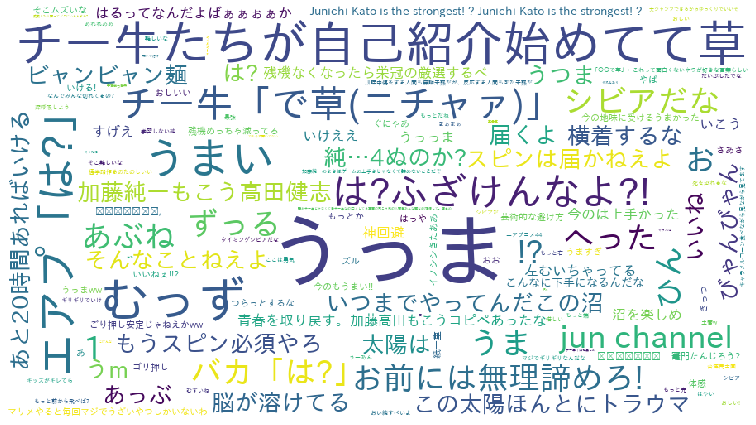

time0 days 05:36:01: 0 days 05:11:01. similarity:0.6847638150992015 https://www.youtube.com/watch?v=RPqSnJez-YI&t=18661


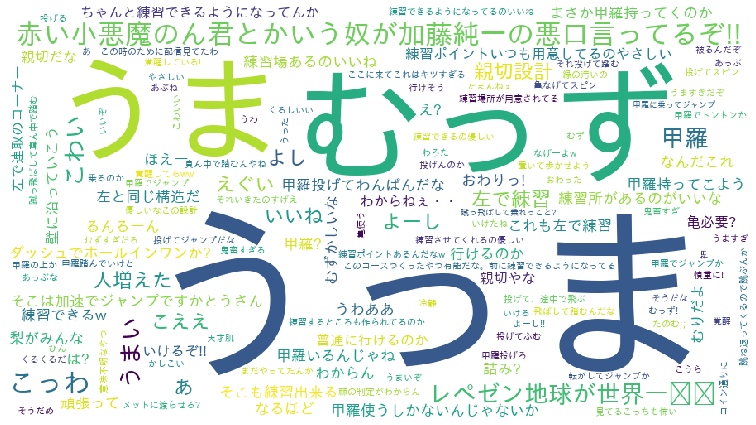

In [124]:
import pandas.tseries.offsets as offsets

index = time_mapper.vk[df_resampled.sort_values('hist', ascending=False).index[6]]
# 類似度上位5件を取得
similar_scenes = sim.get_similar_item_info(sim_mat=cos_sim, index=index, mapper=time_mapper, n=5)
print(similar_scenes)

# 盛り上がったシーンの前後t_offset間のコメントを利用する
t_offset = 30
for i, row in similar_scenes.iterrows():
    target = row['target']
    t = row['item']
    similarity = row['similarity']
    url = df_resampled.loc[t].url
    print('time{0}: {1}. similarity:{2} {3}'.format(target, t, similarity, url))
    wc.create_from_dict(sum(resampled_counter[t-offsets.Second(t_offset):t+offsets.Second(t_offset)], Counter()))    